In [458]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2 as cv

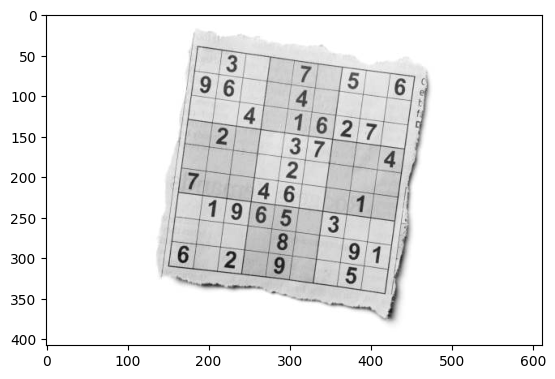

In [459]:
sudoku_colored = cv.imread('sudoku.jpg')
sudoku = cv.cvtColor(sudoku_colored,cv.COLOR_BGR2GRAY)
plt.imshow(sudoku,cmap='gray')

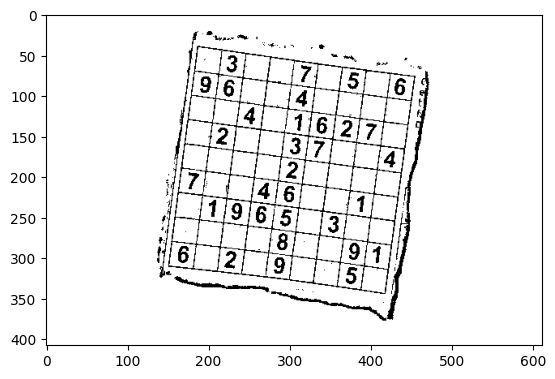

In [460]:
blur = cv.bilateralFilter(sudoku.copy(),9,50,100)
thresh = cv.adaptiveThreshold(blur,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
plt.imshow(thresh,cmap='gray')

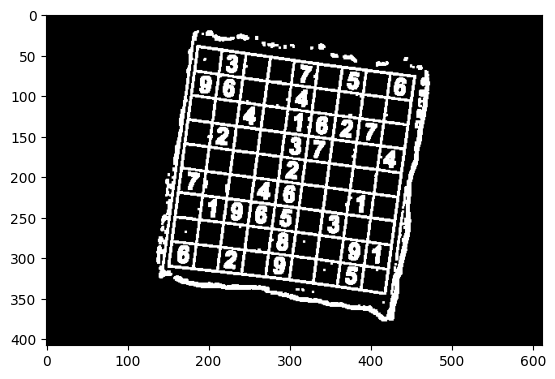

In [461]:
thresh = cv.bitwise_not(thresh, thresh)  
kernel = np.ones((3,3),np.uint8)
thresh = cv.dilate(thresh, kernel)
plt.imshow(thresh,cmap='gray')

In [462]:
contours, h = cv.findContours(thresh.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv.contourArea, reverse=True)
polygon = contours[0]

In [463]:
def findcorners(polygon):
    maxi = -1
    br = []
    tr = []
    bl = []
    tl = []
    for p in polygon:
        point = p[0]
        if(point[0] + point[1] > maxi):
            maxi = point[0] + point[1]
            br = point 

    maxi = -1
    for p in polygon:
        point = p[0]
        if(point[0] - point[1] > maxi):
            maxi = point[0] - point[1]
            tr = point 

    mini = 1e9
    for p in polygon:
        point = p[0]
        if(point[0] + point[1] < mini):
            mini = point[0] + point[1]
            tl = point 

    mini = 1e9
    for p in polygon:
        point = p[0]
        if(point[0] - point[1] < mini):
            mini = point[0] - point[1]
            bl = point 

    return tl ,tr , bl , br

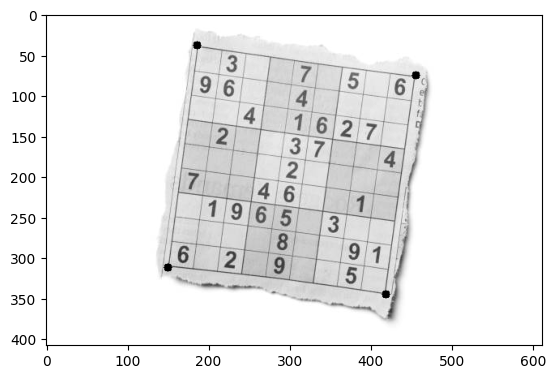

In [464]:
tl , tr, bl , br = findcorners(polygon)
largestcontour = cv.circle(sudoku,tr,5,(0,0,255),-1)
largestcontour = cv.circle(largestcontour,tl,5,(0,0,255),-1)
largestcontour = cv.circle(largestcontour,br,5,(0,0,255),-1)
largestcontour = cv.circle(largestcontour,bl,5,(0,0,255),-1)
plt.imshow(largestcontour,cmap='gray')

In [465]:
largestcontour.shape

(408, 612)

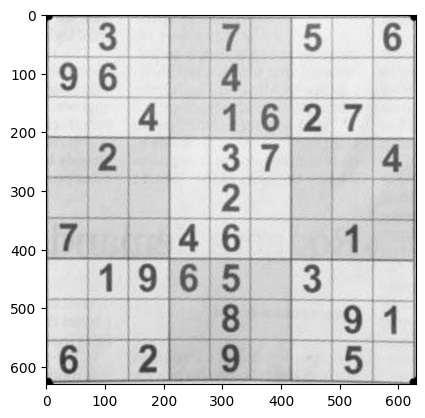

In [466]:
transform_matrix = cv.getPerspectiveTransform(np.array([tl,tr,bl,br],np.float32),np.array([[0,0],[630,0],[0,630],[630,630]],np.float32))
extracted_sudoku = cv.warpPerspective(largestcontour,transform_matrix,(630,630))
plt.imshow(extracted_sudoku,cmap='gray')

In [467]:
extracted_sudoku = cv.bilateralFilter(extracted_sudoku,11,20,20)

In [468]:
digits_images = []
for i in range(9):
    for j in range(9):
        digit = extracted_sudoku[70*i:70*(i+1),70*j:70*(j+1)]
        digits_images.append(digit[7:64,7:64])

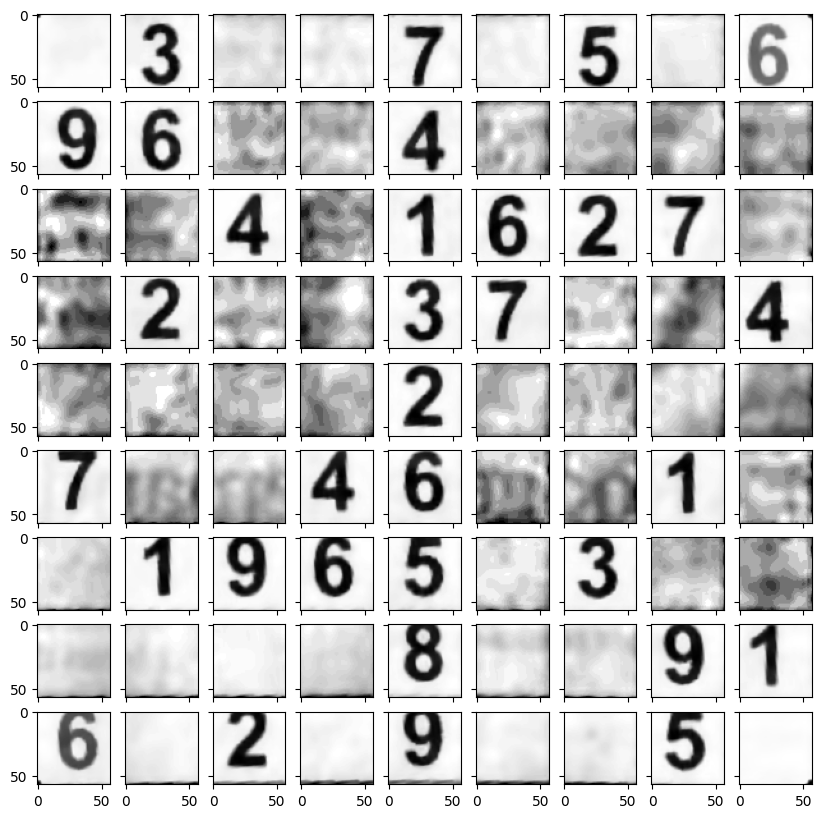

In [469]:
fig , ax = plt.subplots(9,9,figsize=(10,10),sharex=True,sharey=True)
i = 0
for digit in digits_images:
    ax[i//9][i%9].imshow(digit,cmap='gray')
    i = i + 1

In [470]:
count = 0

In [471]:

def extract_digit(img):
    global count
    digit = img.copy()
    digit = cv.GaussianBlur(digit,(11,11),0)
    digit = cv.blur(digit,(5,5))
    digit = cv.adaptiveThreshold(digit,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,15,2)
    # digit = cv.dilate(digit, kernel)
    contours, _= cv.findContours(digit.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    if not contours :
        return np.zeros((128,128))
    largestcontour = max(contours, key=cv.contourArea)
    if cv.contourArea(largestcontour) > 210:
        x, y, w, h = cv.boundingRect(largestcontour)
        digit = digit[y:y+h, x:x+w]
        digit = cv.copyMakeBorder(digit,7,7,7,7,0)
        digit = cv.resize(digit, (128, 128))
        count += 1
        return digit
    else:
        return np.zeros((128,128))

In [472]:
i = 0
extracted_digits = []
for digit in digits_images:
    extracted_digit = extract_digit(digit)
    extracted_digits.append(np.array(extracted_digit))
    i = i + 1

In [473]:
print(f"{count} digits found in given sudoku")

33 digits found in given sudoku


In [474]:
extracted_digits = 255 - np.array(extracted_digits)

In [475]:
extracted_digits.shape

(81, 128, 128)

In [476]:
from keras.models import load_model

In [477]:
model = load_model('best_model.h5.keras')

In [478]:
def predictNumber(img):
    if img.sum()/255 == 128*128:
        return [0 , 1]
    else:
        sample = np.reshape(img,(1,128,128,1)) / 255.0
        y_pred = model.predict(sample,verbose=0)
        y_hat = np.argmax(y_pred,axis=1)
        if np.max(y_pred,axis=1) > 0.95:
            return [y_hat[0] , np.max(y_pred,axis=1)]
        else:
            return [0 , np.max(y_pred,axis=1)]

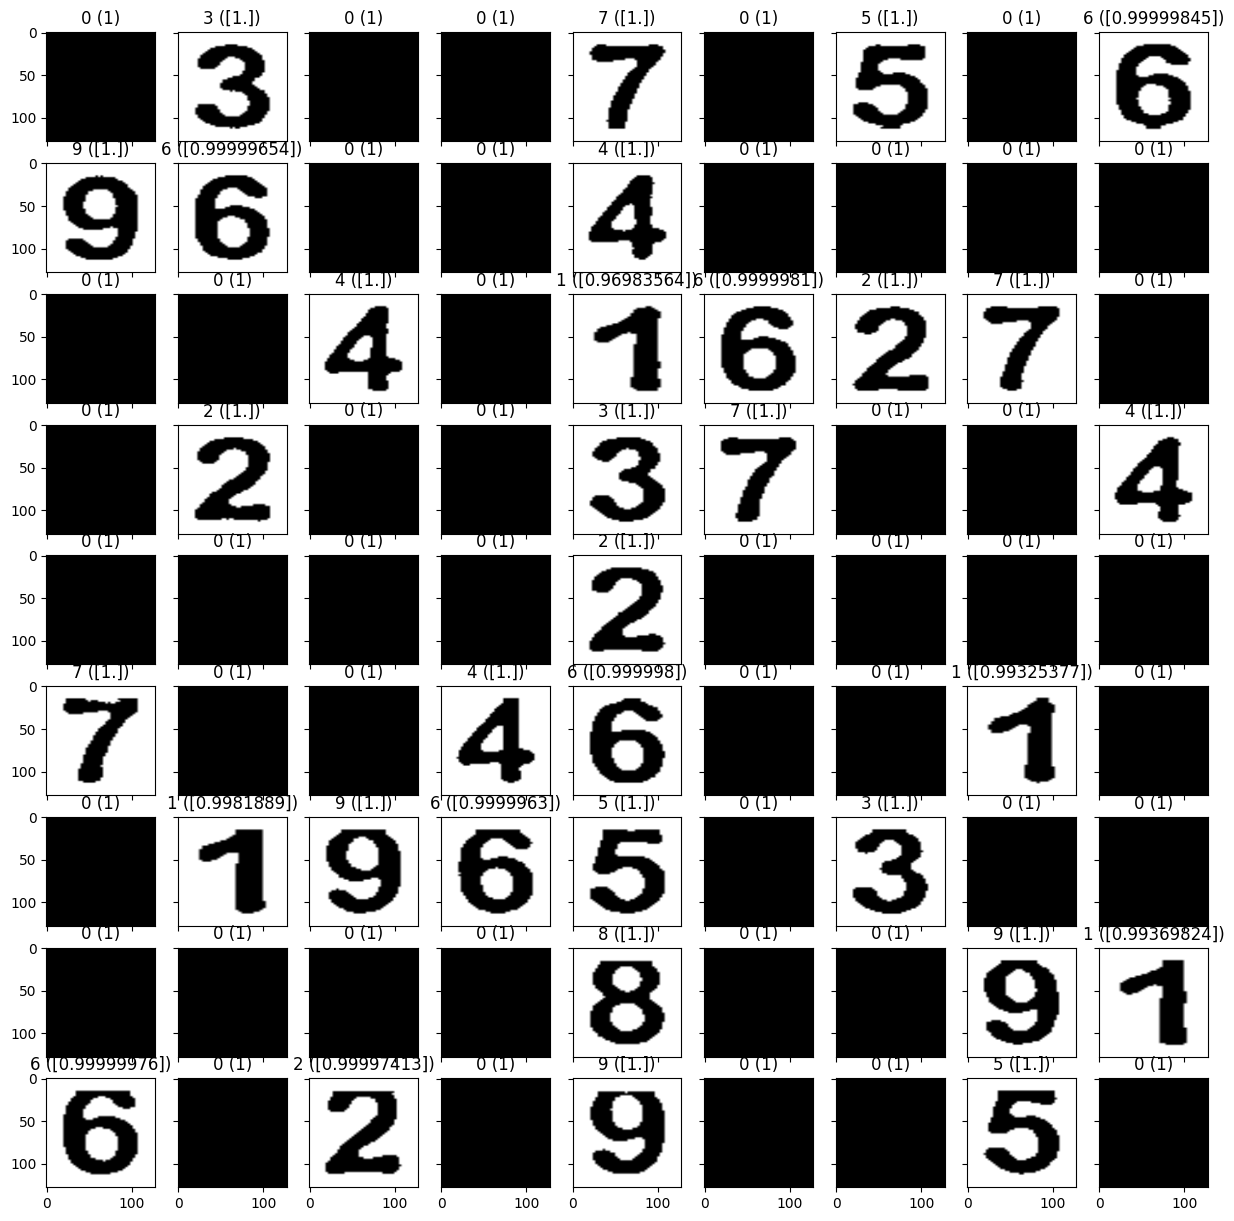

In [479]:
fig , ax = plt.subplots(9,9,figsize=(15,15),sharex=True,sharey=True)
i = 0
grid = []
for img in extracted_digits:
    ax[i//9][i%9].imshow(img,cmap='gray')
    y_hat , acc = predictNumber(img)
    grid.append(str(y_hat))
    ax[i//9][i%9].title.set_text(f'{y_hat} ({acc})')
    i = i + 1

In [480]:
sudoku_grid = []
sudoku_grid.append(grid[:9])
sudoku_grid.append(grid[9:18])
sudoku_grid.append(grid[18:27])
sudoku_grid.append(grid[27:36])
sudoku_grid.append(grid[36:45])
sudoku_grid.append(grid[45:54])
sudoku_grid.append(grid[54:63])
sudoku_grid.append(grid[63:72])
sudoku_grid.append(grid[72:])

In [481]:
sudoku_grid

[['0', '3', '0', '0', '7', '0', '5', '0', '6'],
 ['9', '6', '0', '0', '4', '0', '0', '0', '0'],
 ['0', '0', '4', '0', '1', '6', '2', '7', '0'],
 ['0', '2', '0', '0', '3', '7', '0', '0', '4'],
 ['0', '0', '0', '0', '2', '0', '0', '0', '0'],
 ['7', '0', '0', '4', '6', '0', '0', '1', '0'],
 ['0', '1', '9', '6', '5', '0', '3', '0', '0'],
 ['0', '0', '0', '0', '8', '0', '0', '9', '1'],
 ['6', '0', '2', '0', '9', '0', '0', '5', '0']]

In [482]:
def is_valid(board, row, col, num):
    for i in range(9):
        if board[row][i] == num or board[i][col] == num:
            return False
    start_row, start_col = 3 * (row // 3), 3 * (col // 3)
    for i in range(3):
        for j in range(3):
            if board[start_row + i][start_col + j] == num:
                return False
    return True


def solve_sudoku(board):
    for row in range(9):
        for col in range(9):
            if board[row][col] == '0':
                for num in map(str, range(1, 10)):
                    if is_valid(board, row, col, num):
                        board[row][col] = num
                        if solve_sudoku(board):
                            return True
                        board[row][col] = '0'
                return False
    return True


def print_board(board):
    for row in board:
        print(" ".join(row))


In [483]:
if solve_sudoku(sudoku_grid):
    print("Solved Sudoku:")
    print_board(sudoku_grid)
else:
    print("No solution exists.")

Solved Sudoku:
2 3 1 9 7 8 5 4 6
9 6 7 2 4 5 1 8 3
5 8 4 3 1 6 2 7 9
1 2 8 5 3 7 9 6 4
4 9 6 8 2 1 7 3 5
7 5 3 4 6 9 8 1 2
8 1 9 6 5 4 3 2 7
3 4 5 7 8 2 6 9 1
6 7 2 1 9 3 4 5 8


In [484]:
final_image = np.zeros((630,630,3))

for i in range(81):
    if grid[i] == '0':
        final_image = cv.putText(final_image,str(sudoku_grid[i//9][i%9]),(10+70*(i%9),50+70*(i//9)),cv.FONT_HERSHEY_COMPLEX,1.75,(0,255,255),3,cv.LINE_AA)
    # else:
    #     final_image = cv.putText(final_image,str(sudoku_grid[i//9][i%9]),(10+70*(i%9),50+70*(i//9)),cv.FONT_HERSHEY_COMPLEX,1.5,(0,0,0),2,cv.LINE_AA)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


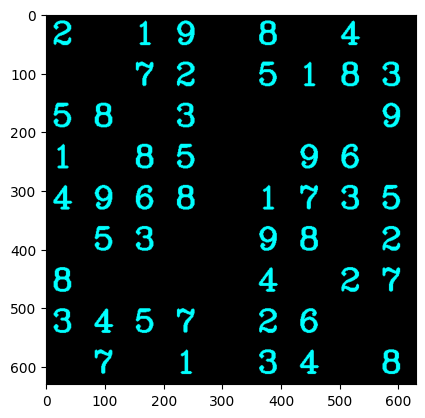

In [485]:
plt.imshow(final_image);

In [486]:
largest_contour = np.array([tl , tr, bl , br],dtype=np.float32)
overlay_matrix = cv.getPerspectiveTransform(np.array([[0,0],[630,0],[0,630],[630,630]],np.float32), largest_contour)
overlay_image = cv.warpPerspective(final_image,overlay_matrix,(sudoku.shape[1],sudoku.shape[0]))

In [487]:
overlayed_sudoku = cv.addWeighted(np.asarray(overlay_image,np.uint8),1,np.asarray(sudoku_colored,np.uint8),0.6,1)

True

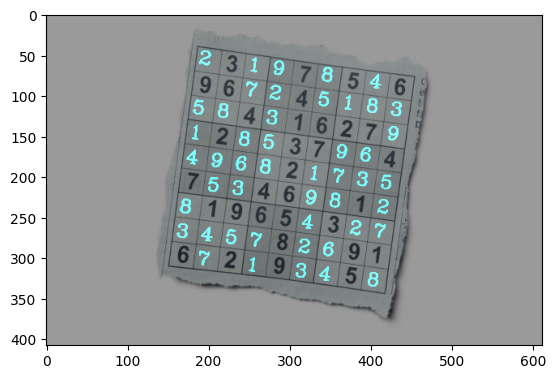

In [489]:
plt.imshow(overlayed_sudoku);
cv.imwrite('Output.jpg',overlayed_sudoku)